In [ ]:
# http://geotiff.maptools.org/STDI-0002_v2.1.pdf (Section 8.4.2)

In [244]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import xarray as xr
import os
from scipy.optimize import curve_fit

In [245]:
g17_b02 = xr.open_dataset('/home/jovyan/goes17/2018/12/12/ABI-L1b-RadC/18/C02/OR_ABI-L1b-RadC-M3C02_G17_s20183461827189_e20183461829502_c20183461829528.nc')

In [246]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0 - np.degrees( np.arctan( Sy / ( H - Sx )) )
    
    return (lat,lon)



In [247]:
# make a 2d array of both x and y in radians
x, y = np.meshgrid(g17_b02.x.values, g17_b02.y.values)

# Values needed for geometry calculations
req = g17_b02.goes_imager_projection.semi_major_axis # semi major axis
rpol = g17_b02.goes_imager_projection.semi_minor_axis
H = g17_b02.goes_imager_projection.perspective_point_height + g17_b02.goes_imager_projection.semi_major_axis
lon_0 = g17_b02.goes_imager_projection.longitude_of_projection_origin

# Get lat and lon values
lat, lon = ABIangle2LatLon(x,y,H,req,rpol,lon_0)


In [248]:
# Pixel coordinates of x and y:
xs = np.linspace(0,g17_b02.x.shape[0],g17_b02.x.shape[0],dtype='int16')
ys = np.linspace(0,g17_b02.y.shape[0],g17_b02.y.shape[0],dtype='int16')
x, y = np.meshgrid(xs,ys)

In [249]:
# Normalize latitude to [-1,1]:
LAT_OFF = lat.min()
LAT_SCALE = lat.max()-lat.min()
lat_norm = 2 * ((lat - LAT_OFF) / LAT_SCALE) - 1

# Normalize longitude to [-1,1]:
LON_OFF = lon.min()
LON_SCALE = lon.max() - lon.min()
lon_norm = 2 * ((lon - LON_OFF) / LON_SCALE) - 1

# Normalize row (y) to [-1,1]:
Y_OFF = y.min()
Y_SCALE = y.max() - y.min()
y_norm = 2 * ((y - Y_OFF) / Y_SCALE) - 1

# Normalize column (x) to [-1,1]:
X_OFF = x.min()
X_SCALE = x.max() - x.min()
x_norm = 2 * ((x - X_OFF) / X_SCALE) - 1

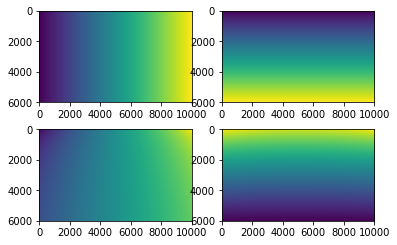

In [7]:
# Visualize the arrays of x, y (scan angle radians), and longitude, latitude (degrees)
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x_norm)
ax[0,1].imshow(y_norm)
ax[1,0].imshow(lon_norm)
ax[1,1].imshow(lat_norm)

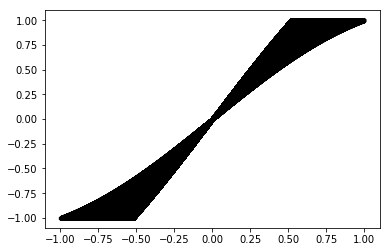

In [81]:
# Visualize longitude (degrees) vs x (scan angle radians)
plt.plot(lon_norm,x_norm,'.k',alpha=0.01);

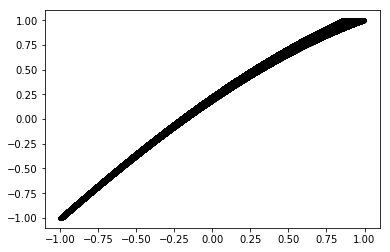

In [12]:
# Visualize latitude (degrees) vs y (scan angle radians)
plt.plot(lat_norm,y_norm,'.k',alpha=0.01);

In [250]:
# Fit RPCs to these two surfaces:

#do 2 fittings for x and y seperately (here l and s)
#function accepts 2 tuples as input first contains x,y,z and 2nd contains 40 coefficients
#using scipy curve fitting wont require to initialise the tuples

# https://stackoverflow.com/questions/19165259/python-numpy-scipy-curve-fitting
    

In [251]:
def map2rpc(in_xyz,
            a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,
            b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19):
    
    x, y, z = in_xyz
    
    num_l = a0 + a1*x + a2*y + a3*z + a4*x*y + a5*x*z + a6*y*z + a7*x**2 + a8*y**2 + a9*z**2 + a10*x*y*z + a11*x**3 + a12*x*y**2 + \
    a13**x*z**2 + a14*y*x**2 + a15*y**3 + a16*y*z**2 + a17*x**2*z + a18*y**2*z + a19*z**3
    
    den_l = b0 + b1*x + b2*y + b3*z + b4*x*y + b5*x*z + b6*y*z + b7*x**2 + b8*y**2 + b9*z**2 + b10*x*y*z + b11*x**3 + b12*x*y**2 + \
    b13**x*z**2 + b14*y*x**2 + b15*y**3 + b16*y*z**2 + b17*x**2*z + b18*y**2*z + b19*z**3
    
    return num_l/den_l

In [252]:
# set elevations to 0, on the surface of the ellipsoid??
z_norm = np.zeros_like(lat_norm)

In [253]:
# Pick out n random indices to use for fitting
n = 1000000
idx1 = np.random.randint(0, z_norm.shape[0], n)
idx2 = np.random.randint(0, z_norm.shape[0], n)

In [254]:
a = curve_fit(map2rpc, 
              [lon_norm[idx1,idx2].flatten(), lat_norm[idx1,idx2].flatten() ,z_norm[idx1,idx2].flatten()], 
              x_norm[idx1,idx2].flatten())

/home/jovyan/my-conda-envs/goes/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [230]:
b = curve_fit(map2rpc, 
              [lon_norm[idx1,idx2].flatten(), lat_norm[idx1,idx2].flatten() ,z_norm[idx1,idx2].flatten()], 
              y_norm[idx1,idx2].flatten())

In [255]:
a

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]), array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]))

In [231]:
b

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]), array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]))

In [239]:
fit_x = map2rpc((x_norm.flatten(),y_norm.flatten(),z.flatten()),*a[0])

/home/jovyan/my-conda-envs/goes/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [240]:
fit_y = map2rpc((x_norm.flatten(),y_norm.flatten(),z.flatten()),*b[0])

/home/jovyan/my-conda-envs/goes/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [222]:
############# fake data testing


In [204]:
n = 1000000
x = np.linspace(0,1, n)
y = np.linspace(0,1, n)
z = np.linspace(0,1, n)
a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19 = np.random.randint(0,20,20)
b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19 = np.random.randint(0,20,20)
true_coeffs = np.array([a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19])
# true values of all these coefficients
true = map2rpc((x,y,z),a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,
            a15,a16,a17,a18,a19,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,
            b12,b13,b14,b15,b16,b17,b18,b19)
noisy = true  + ( np.random.random(n) - np.random.random(n) ) / 50

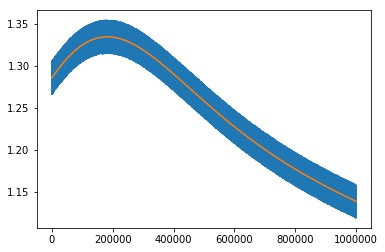

In [206]:
plt.plot(noisy)
plt.plot(true)

In [216]:
popt, pcov = curve_fit(map2rpc, (x,y,z), noisy)
print(popt, pcov)

/home/jovyan/my-conda-envs/goes/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()
/home/jovyan/my-conda-envs/goes/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


[ 1.68959271  0.06970307  0.0857265   0.10501283  0.6404589   0.66581108
  0.65807292  0.67319635  0.65957505  0.73094333  0.11114823  0.0614784
  0.08616071  5.80052123  0.16045414  0.1500663  -0.1219719   0.05530175
  0.12706672 -0.15715942  1.31408048 -0.10771536 -0.09090761 -0.13825567
  0.8123797   0.49142376  0.59877969  0.92226599  0.69972927  0.74364127
  0.03824799  0.03767292 -0.21268686  5.89313396  0.08010598  0.10114148
 -0.13978493 -0.13528278 -0.17550452  0.02379955] [[inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]


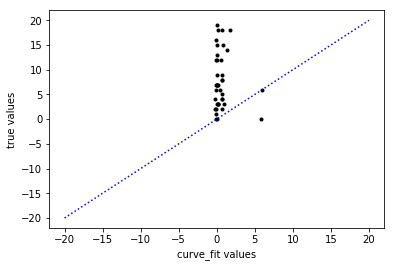

In [217]:
plt.plot(popt,true_coeffs,'.k')
plt.ylabel('true values')
plt.xlabel('curve_fit values')
plt.plot([-20,20],[-20,20],':b')

In [218]:
fit = map2rpc((x,y,z),*popt)

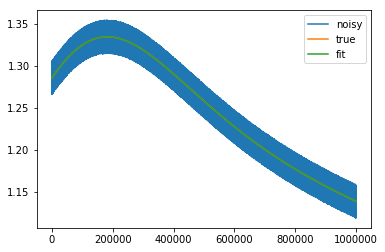

In [219]:
plt.plot(noisy,label="noisy")
plt.plot(true,label="true")
plt.plot(fit,label="fit")
plt.legend()

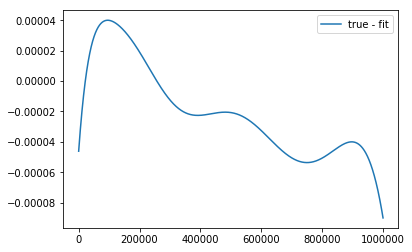

In [221]:
#plt.plot(true - noisy,label="true - noisy")
plt.plot(true - fit,label="true - fit")
plt.legend()